# CNN Based Heuristic Approximation

Let's explore how CNN architectures can approximate the heuristic map.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np


class MapDataLoader(torch.utils.data.Dataset):
    def __init__(self,file,root="./"):
        self.data = np.load(os.path.join(root,file))
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,index):
        return self.data[index][0],self.data[index][1]

In [153]:
class Network(nn.Module):
    def __init__(self,N):
        super(Network,self).__init__()
        self.layer1   = nn.Sequential(
           nn.Conv2d(1,5,kernel_size=5,stride=1,padding='same'),
           nn.BatchNorm2d(5),
           nn.ReLU() 
        )
        self.layer2 = nn.Sequential(
           nn.Conv2d(5,10,kernel_size=5,stride=1,padding='same'),
           nn.BatchNorm2d(10),
           nn.ReLU(),
           nn.MaxPool2d(2,2)
        )
        self.fc1   = nn.Linear(10*5*5,500)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(500,N*N) 
        self.sig   = nn.Sigmoid()
        
    def forward(self,x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = torch.reshape(y,(-1,10*5*5))
        y = self.fc1(y)
        y = self.relu1(y)
        y = self.fc2(y) 
        y = self.sig(y)
        return y

In [154]:
from torch import tensor
mseloss = torch.nn.MSELoss()
def map_loss(inputs,outputs,labels,p1=0.0,p2=0.0):
    At = inputs.detach().clone()
    Bt = outputs.clone()
    Ct = torch.zeros(At.shape)
    Dt = torch.zeros(At.shape)
    mask1 = At > 0.6
    mask2 = torch.logical_and(At > 0.49,At < 0.51)
    Ct[mask1] = 1.0
    Dt[mask2] = 1.0
    loss1 = mseloss(outputs,labels)
    loss2 = torch.mean(torch.norm(p1*(Ct*Bt),dim=0))
    loss3 = torch.mean(torch.norm(p2*(Dt-Dt*Bt),dim=0))
    loss = loss1+loss2+loss3
    return loss

In [155]:
data_location = '10by10_Obs'
N = 10
network = Network(N)

In [156]:
learning_rate = 0.001
numEpochs = 20
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)

In [157]:
train_loader = torch.utils.data.DataLoader(dataset=MapDataLoader('dataset_train.npy',data_location),batch_size=30,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=MapDataLoader('dataset_test.npy',data_location),batch_size=30,shuffle=False)
total_steps = len(train_loader)

In [158]:
testid = 'CNN_10x10_obs'
p1 = 0.0
p2 = 0.0
network.train()
for epoch in range(numEpochs):
    avg_loss = 0
    for i,(data,label) in enumerate(train_loader):
        inputs = data.reshape(-1,1,N,N).float()
        labels = label.reshape(-1,N**2).float()
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = mseloss(outputs,labels)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= total_steps
    print('Average loss after epoch %d:%f' % (epoch+1,avg_loss))
  
          
torch.save(network,os.path.join(data_location,testid+'.pt'))

Average loss after epoch 1:0.055012
Average loss after epoch 2:0.045594
Average loss after epoch 3:0.029952
Average loss after epoch 4:0.025753
Average loss after epoch 5:0.022503
Average loss after epoch 6:0.020398
Average loss after epoch 7:0.018660
Average loss after epoch 8:0.017031
Average loss after epoch 9:0.015833
Average loss after epoch 10:0.014986
Average loss after epoch 11:0.014298
Average loss after epoch 12:0.013810
Average loss after epoch 13:0.013357
Average loss after epoch 14:0.013007
Average loss after epoch 15:0.012737
Average loss after epoch 16:0.012511
Average loss after epoch 17:0.012278
Average loss after epoch 18:0.012092
Average loss after epoch 19:0.011906
Average loss after epoch 20:0.011730


In [160]:
## Evaluate network on test data

#network = torch.load(os.path.join(data_location,testid+'.pt'))
network.eval()
from MapGenerator import PlotMap
loss = 0
test_size = len(test_loader)
with torch.no_grad():
    for (data,label) in test_loader:
        inputs = data.reshape(-1,1,N,N).float()
        labels = label.reshape(-1,N**2).float()    
        outputs = network(inputs)
        loss +=  mseloss(outputs,labels)
    loss /= test_size
    print('Average testing loss: %f' %(loss))

Average testing loss: 0.012292


In [161]:
with torch.no_grad():
    data,label = next(iter(train_loader))
    inputs = data.reshape(-1,1,N,N).float()
    labels = label.reshape(-1,N**2).float()    
    outputs = network(inputs)

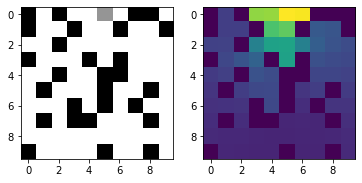

In [166]:
eg = 27
PlotMap(data[eg],label[eg])

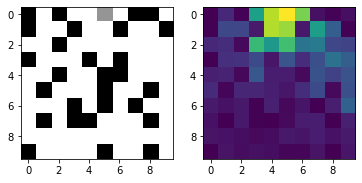

In [167]:
PlotMap(data[eg],outputs[eg].reshape(N,N))